# Info

Function:
* Rename metrics df columns for easier use
* Remove outliers
* Identify metric rows in an easy to use format
* Save result to be loaded in other notebooks

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from general_utils import utils
utils.default_plot_format()

data_path = r'processed_data/optimized_10min_Nabian.pkl'
result_path = "processed_data/optimized_raw_10min_Nabian.pkl"

# Preparing and renaming column

In [166]:
data = pd.read_pickle(data_path)
data.tail(3)

,t_start,t_end,SDRR,RMSSD,pNN50 (%),Mean HR (bpm),ULF Power,ULF Peak Frequency,VLF Power,VLF Peak Frequency,...,UMA (mg),UCr (g),UACR (mg/g),Diabetic Complications,Diabetic nephropathy,Diabetic retinopathy and cataract,Diabetic peripheral neuropathy,Coronary artery disease and cardiac insufficiency,Lower extremity atherosclerosis or stenosis,Carotid plaque
5372,75103.344,75701.976,90.297380,116.554065,4.087193,73.571119,0.079674,0.000000,0.273977,0.033410,...,4.38,10.23,0.428152,1.0,0.0,0.0,1.0,0.0,0.0,1.0
5373,75703.428,76302.748,141.746201,199.345544,34.105534,77.700026,0.388217,0.000000,3.339979,0.035040,...,4.38,10.23,0.428152,1.0,0.0,0.0,1.0,0.0,0.0,1.0
5374,76303.532,76903.204,173.745127,220.184953,22.222222,74.743195,0.031038,0.001668,11.725014,0.035019,...,4.38,10.23,0.428152,1.0,0.0,0.0,1.0,0.0,0.0,1.0


Keep only individuals with no complications or diabetic neuropathy only.
Rename the columns in a ways that is easier to follow.

In [167]:
data.rename(columns={
    'Diabetic Complications': 'Complications',
    'Diabetic nephropathy': 'Nephropathy',
    'Diabetic retinopathy and cataract': 'Retinopathy and cataract',
    'Diabetic peripheral neuropathy': 'DPN',
    'Coronary artery disease and cardiac insufficiency': 'Heart Disease',
    'Lower extremity atherosclerosis or stenosis': 'atherosclerosis or stenosis',
    'Carotid plaque': 'Carotid Plaque'
}, inplace=True)

In [168]:
data.sort_values(by=["DPN"], inplace=True)
new_id = {ID:i for i, ID in enumerate(data.id.unique())}
data.id = data.id.map(new_id)
data.id.unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42], dtype=int64)

In [169]:
conditions = data[['id', 'Complications', 'Nephropathy',
       'Retinopathy and cataract', 'DPN', 'Heart Disease',
       'atherosclerosis or stenosis', 'Carotid Plaque']]
conditions = conditions.drop_duplicates().sort_values('DPN')
conditions = conditions.reset_index(drop=True)

display(conditions)

,id,Complications,Nephropathy,Retinopathy and cataract,DPN,Heart Disease,atherosclerosis or stenosis,Carotid Plaque
0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,22,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,24,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,25,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,26,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,27,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,28,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,29,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,30,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [170]:
data = data[(data["Complications"] == 0) | (data["DPN"] == 1)]
data["DPN"] = data["DPN"].astype(bool)

data['Condition'] = data['DPN'].apply(lambda x: 'DPN' if x else 'Diabetes')
data.tail()

,t_start,t_end,SDRR,RMSSD,pNN50 (%),Mean HR (bpm),ULF Power,ULF Peak Frequency,VLF Power,VLF Peak Frequency,...,UCr (g),UACR (mg/g),Complications,Nephropathy,Retinopathy and cataract,DPN,Heart Disease,atherosclerosis or stenosis,Carotid Plaque,Condition
4234,22211.544,22811.504,30.886515,24.631622,3.132832,79.796796,0.003556,0.000000,0.642324,0.035002,...,7.26,2.878788,1.0,1.0,0.0,True,0.0,0.0,1.0,DPN
4233,21610.780,22210.728,40.473031,34.099816,13.032258,77.498219,0.003058,0.000000,0.680535,0.038337,...,7.26,2.878788,1.0,1.0,0.0,True,0.0,0.0,1.0,DPN
4232,21009.972,21609.940,38.711144,41.980558,27.344782,75.706124,0.000517,0.001667,1.258882,0.030002,...,7.26,2.878788,1.0,1.0,0.0,True,0.0,0.0,1.0,DPN
4254,34218.232,34817.652,88.513079,31.706090,12.610340,79.374071,0.004075,0.001668,0.980049,0.030029,...,7.26,2.878788,1.0,1.0,0.0,True,0.0,0.0,1.0,DPN
5374,76303.532,76903.204,173.745127,220.184953,22.222222,74.743195,0.031038,0.001668,11.725014,0.035019,...,10.23,0.428152,1.0,0.0,0.0,True,0.0,0.0,1.0,DPN


In [171]:
# Create functions to find the peak frequency and power
def find_peak_frequency(row):
    # Get the peak frequencies
    vlf_peak = row['VLF Peak Frequency']
    lf_peak = row['LF Peak Frequency']
    hf_peak = row['HF Peak Frequency']
    
    # Get the corresponding powers
    vlf_power = row['VLF Power']
    lf_power = row['LF Power']
    hf_power = row['HF Power']
    
    # Find the maximum power
    powers = [vlf_power, lf_power, hf_power]
    peak_power_index = powers.index(max(powers))
    
    # Return the corresponding peak frequency
    frequencies = [vlf_peak, lf_peak, hf_peak]
    return frequencies[peak_power_index]

def find_peak_power(row):
    # Return the maximum power among VLF, LF, and HF
    vlf_power = row['VLF Power']
    lf_power = row['LF Power']
    hf_power = row['HF Power']
    
    return max(vlf_power, lf_power, hf_power)

# Add the new columns to the dataframe
data['Peak Power'] = data.apply(find_peak_power, axis=1)
data['Peak Frequency'] = data.apply(find_peak_frequency, axis=1)


In [172]:
data.columns = data.columns.str.replace('/', '÷')
print(data.columns)

Index(['t_start', 't_end', 'SDRR', 'RMSSD', 'pNN50 (%)', 'Mean HR (bpm)',
       'ULF Power', 'ULF Peak Frequency', 'VLF Power', 'VLF Peak Frequency',
       'LF Power', 'LF Peak Frequency', 'HF Power', 'HF Peak Frequency',
       'LF÷HF Ratio', 'S', 'SD1', 'SD2', 'SD1÷SD2', 'ApEn', 'SampEn', 'DFA α1',
       'DFA α2', 'D2', 'id', 'gender', 'age', 'height', 'weight',
       'admission FBG (mmol÷L)', 'Discharge FBG (mmol÷L)', 'HbA1c (%)',
       'SBP (mmHg)', 'DBP (mmHg)', 'WBC (×109÷L)', 'N% (%)', 'Hb (g÷L)',
       'PLT (×109÷L)', 'CRP (mg÷L)', 'ALT (U÷L)', ' AST (U÷L)', 'AST÷ALT',
       'GGT (U÷L)', 'BUN (mmol÷L)', ' UA (mmol÷L)', 'TG (mmol÷L)',
       'HDL-C (mmol÷L)', 'LDL-C (mmol÷L)', 'UMA (mg)', 'UCr (g)',
       'UACR (mg÷g)', 'Complications', 'Nephropathy',
       'Retinopathy and cataract', 'DPN', 'Heart Disease',
       'atherosclerosis or stenosis', 'Carotid Plaque', 'Condition',
       'Peak Power', 'Peak Frequency'],
      dtype='object')


In [173]:
time_metrics = ['SDRR', 'RMSSD', 'pNN50 (%)', 'Mean HR (bpm)']
frequency_metrics = ['Peak Frequency', 'Peak Power', 'VLF Power',
       'VLF Peak Frequency', 'LF Power', 'LF Peak Frequency', 'HF Power',
       'HF Peak Frequency', 'LF÷HF Ratio']
non_linear_metrics = ['S', 'SD1', 'SD2', 'SD1÷SD2',
       'ApEn', 'SampEn', 'DFA α1', 'DFA α2', 'D2']

indicator_columns = [*time_metrics, *frequency_metrics, *non_linear_metrics]
indicator_columns

['SDRR',
 'RMSSD',
 'pNN50 (%)',
 'Mean HR (bpm)',
 'Peak Frequency',
 'Peak Power',
 'VLF Power',
 'VLF Peak Frequency',
 'LF Power',
 'LF Peak Frequency',
 'HF Power',
 'HF Peak Frequency',
 'LF÷HF Ratio',
 'S',
 'SD1',
 'SD2',
 'SD1÷SD2',
 'ApEn',
 'SampEn',
 'DFA α1',
 'DFA α2',
 'D2']

# ECG and outliers

3255


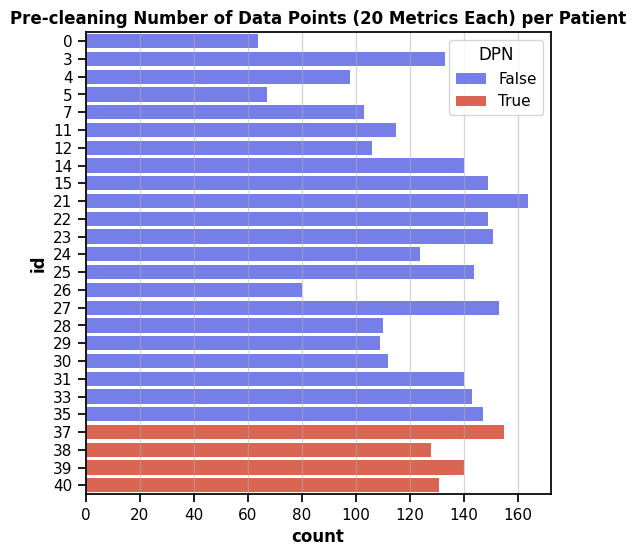

In [174]:
print(data.shape[0])
plt.figure(figsize=(6, 6))
sns.countplot(data, y='id', hue = 'DPN')
plt.title("Pre-cleaning Number of Data Points (20 Metrics Each) per Patient")
plt.grid(axis='x', alpha = 0.5)

# Outlier removal

In [175]:
from general_utils.OverallDetailComparisonPlot import OverallDetailComparisonPlot

def draw_dist(metric, data = data):
    plotter = OverallDetailComparisonPlot(data=data, 
    x_column="id",
    y_column=metric,
    hue_column="DPN",
    title=f"distribution in {metric}",
    detail_mode='box',
    points = "all")

    plotter.override_hover_data(["t_start", "t_end", "id", metric])
    plotter.setup_general_layout(1200, 400, 1/10)
    plotter.show()
    return plotter

## Outlier removal
We remove all outliers using patient by patient approach.

In [176]:
import numpy as np
import pandas as pd

def find_patient_metric_outliers(data, metric, patient_id, threshold=1.5):
    """Finds IQR outliers for patient metric"""
    patient = data[data["id"] == patient_id]
    q1 = patient[metric].quantile(0.25)
    q3 = patient[metric].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - threshold * iqr
    upper_bound = q3 + threshold * iqr
    outliers = patient[(patient[metric] < lower_bound) | (patient[metric] > upper_bound)]
    return outliers, lower_bound, upper_bound


In [177]:
threshold = 10

def check_outliers(data, metric):
    """Returns a list of outliers for each patient for each metric"""
    outlier_table = pd.DataFrame()
    for patient in data.id.unique():

        outliers, lower_bound, upper_bound = find_patient_metric_outliers(data, metric, patient, threshold)

        if not outliers.empty:

            df = pd.DataFrame({
                "patient": patient,
                "DPN" : data[data["id"] == patient]["DPN"].values[0],
                "metric": metric,
                "t_start": outliers["t_start"].values,
                "t_end": outliers["t_end"].values,
                "o_values": outliers[metric].values,
                "lower_bound": lower_bound,
                "upper_bound": upper_bound
            })

            outlier_table = pd.concat([outlier_table, df])
    return outlier_table.reset_index(drop=True)

check_outliers(data, "SDRR").tail()

,patient,DPN,metric,t_start,t_end,o_values,lower_bound,upper_bound
21,31,False,SDRR,32424.128,33024.044,19044.651322,-1176.256074,1470.935135
22,33,False,SDRR,79249.188,79848.896,4632.090566,-593.107081,765.603403
23,33,False,SDRR,85253.848,85853.408,4711.372736,-593.107081,765.603403
24,38,True,SDRR,34875.292,35474.524,8835.514297,-596.065396,754.767928
25,38,True,SDRR,34219.976,34629.036,1046.216731,-596.065396,754.767928


In [178]:
full_outliers = pd.DataFrame()
for metric in indicator_columns:
    outliers = check_outliers(data, metric)
    full_outliers = pd.concat([full_outliers, outliers])
    full_outliers = full_outliers.reset_index(drop=True)
full_outliers.tail()    

,patient,DPN,metric,t_start,t_end,o_values,lower_bound,upper_bound
494,33,False,DFA α1,85253.848,85853.408,-1.173323,-0.847122,2.450689
495,14,False,D2,19811.536,20410.796,-38.871890,-28.727325,23.991615
496,37,True,D2,51636.636,52236.348,-53.700853,-43.005754,32.191549
497,37,True,D2,51036.572,51635.952,-163.692720,-43.005754,32.191549
498,37,True,D2,66044.476,66643.920,36.326881,-43.005754,32.191549


### Are outlier more clustered around certain patients?

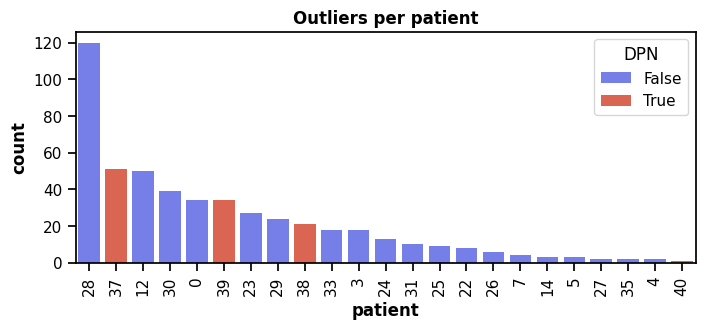

In [179]:
def draw_outlying_patients(full_outliers):
    plt.figure(figsize=(8, 3))
    # Count outliers per patient and DPN status
    patient_counts = full_outliers.groupby(['patient', 'DPN']).size().reset_index(name='count')
    patient_order = patient_counts.groupby('patient')['count'].sum().sort_values(ascending=False).index

    # Create the countplot with sorted patients
    sns.countplot(data=full_outliers, x="patient", hue="DPN", order=patient_order)
    plt.title("Outliers per patient")
    plt.xticks(rotation=90);
draw_outlying_patients(full_outliers)

* Individual with most outliers had DPN.
    * This individual appears to have outlying more outliers
* DPN individuals could be producing more outliers; however it could be just small sample effect.
* There is a lot outlier number variance between individuals.

### Which metrics are most prone to outliers?

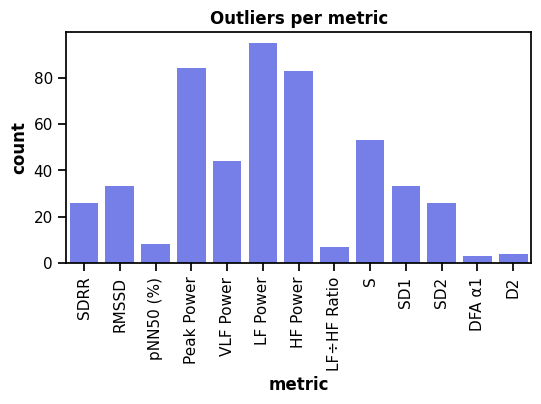

In [180]:
plt.figure(figsize=(6, 3))
sns.countplot(data=full_outliers, x="metric")
plt.title("Outliers per metric")
plt.xticks(rotation=90);

Remove outliers from linear domain metrics.

There is something going on with frequency components. Linear metrics appear to be cleanest

total outliers: 132


Text(0.5, 1.0, 'Number of Outliers per ECG segment')

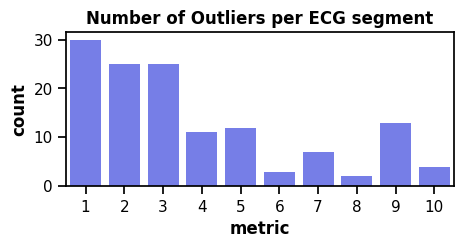

In [181]:
outlier_counts = full_outliers.groupby(["patient", "t_start"]).agg({"metric": "count"}).sort_values("metric", ascending=False)
print("total outliers:", outlier_counts.shape[0])
plt.figure(figsize=(5, 2))
sns.countplot(data=outlier_counts, x="metric")
plt.title("Number of Outliers per ECG segment")

A segment with numerous outlying values likely indicates and error in ECG measurement.
**TODO: CONFIRM IT THE MANUALLY WAY**

* Poisson distribution in outliers would indicate randomness, however, the tail is too long.
* Most outliers are single instance only.

Since segments with multiple outliers indicate errors in measurement procedure, they will be removed.

Disable automatic outlier removal for now

In [182]:
print(data.shape)

outlier_counts = outlier_counts[outlier_counts["metric"] > 0]
patient_mask = data["id"].isin(outlier_counts.index.get_level_values(0))
time_start_mask = data["t_start"].isin(outlier_counts.index.get_level_values(1))
#data = data[~(patient_mask & time_start_mask)]

print(data.shape)


(3255, 61)
(3255, 61)


Discarded 1/6th of the values. This is unacceptable and caused by Errors in the PSD metric calculation and functions Need to fix ASAP.

## Manual Cleaning

### Time Metrics

In [183]:
save = data

In [184]:
data =save

### SDRR

Some obvious outliers removed by hand above

## Data density

3255


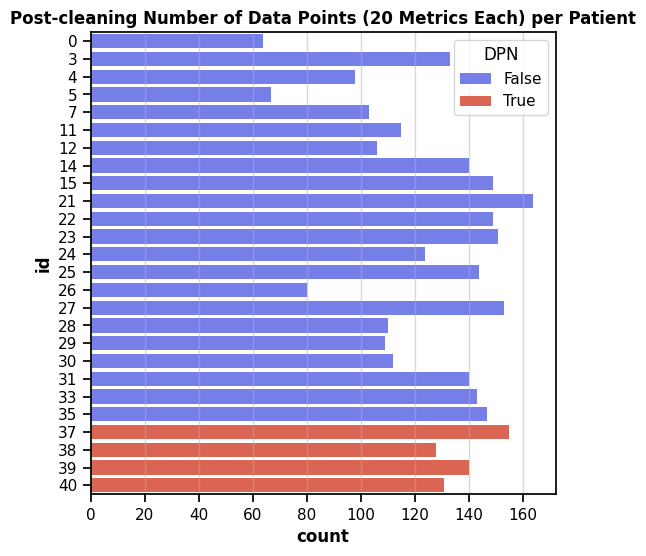

In [185]:
print(data.shape[0])

data.reset_index(drop=True, inplace=True)
plt.figure(figsize=(6, 6))
sns.countplot(data, y='id', hue = 'DPN')
plt.title("Post-cleaning Number of Data Points (20 Metrics Each) per Patient")
plt.grid(axis='x', alpha = 0.5)

The DPN patients are not significantly undersampled, which is good.

TODO: Decide whether the >60 patients are grounds for concern

# Save the data

In [186]:
import pickle

# Create a dictionary to store the data and metrics
data_to_pickle = {
    'data': data,
    'indicator_columns': indicator_columns,
    'time_metrics': time_metrics,
    'frequency_metrics': frequency_metrics,
    'non_linear_metrics': non_linear_metrics
}


# Save the dictionary to a pickle file
with open(result_path, 'wb') as file:
    pickle.dump(data_to_pickle, file)